## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [36]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

## Prepare the data set

In [37]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [38]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [39]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [40]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [41]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [42]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [43]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [44]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
title        object
dtype: object

In [45]:
target = 'survived'

In [46]:
vars_num = data.select_dtypes(include=['int64', 'float64']).columns.tolist() # fill your code here
vars_num.remove(target)
vars_cat = data.select_dtypes(include=['object']).columns.tolist()# fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Numerical variables columns names:',vars_num)
print('Number of categorical variables: {}'.format(len(vars_cat)))
print('Categorical Variables columns names:',vars_cat)

Number of numerical variables: 5
Numerical variables columns names: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Number of categorical variables: 4
Categorical Variables columns names: ['sex', 'cabin', 'embarked', 'title']


### Find missing values in variables

In [47]:
# first in numerical variables
var_num_na = [var for var in vars_num if data[var].isnull().sum()>0] #numerical variables with missing values
var_num_na

['age', 'fare']

In [51]:
# now in categorical variables
var_cat_na = [var for var in vars_cat if data[var].isnull().sum()>0] #categorical variables with missing values
var_cat_na

['cabin', 'embarked']

### Determine cardinality of categorical variables

In [49]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

In [50]:
data[vars_cat].isnull().sum()

sex            0
cabin       1014
embarked       2
title          0
dtype: int64

### Determine the distribution of numerical variables

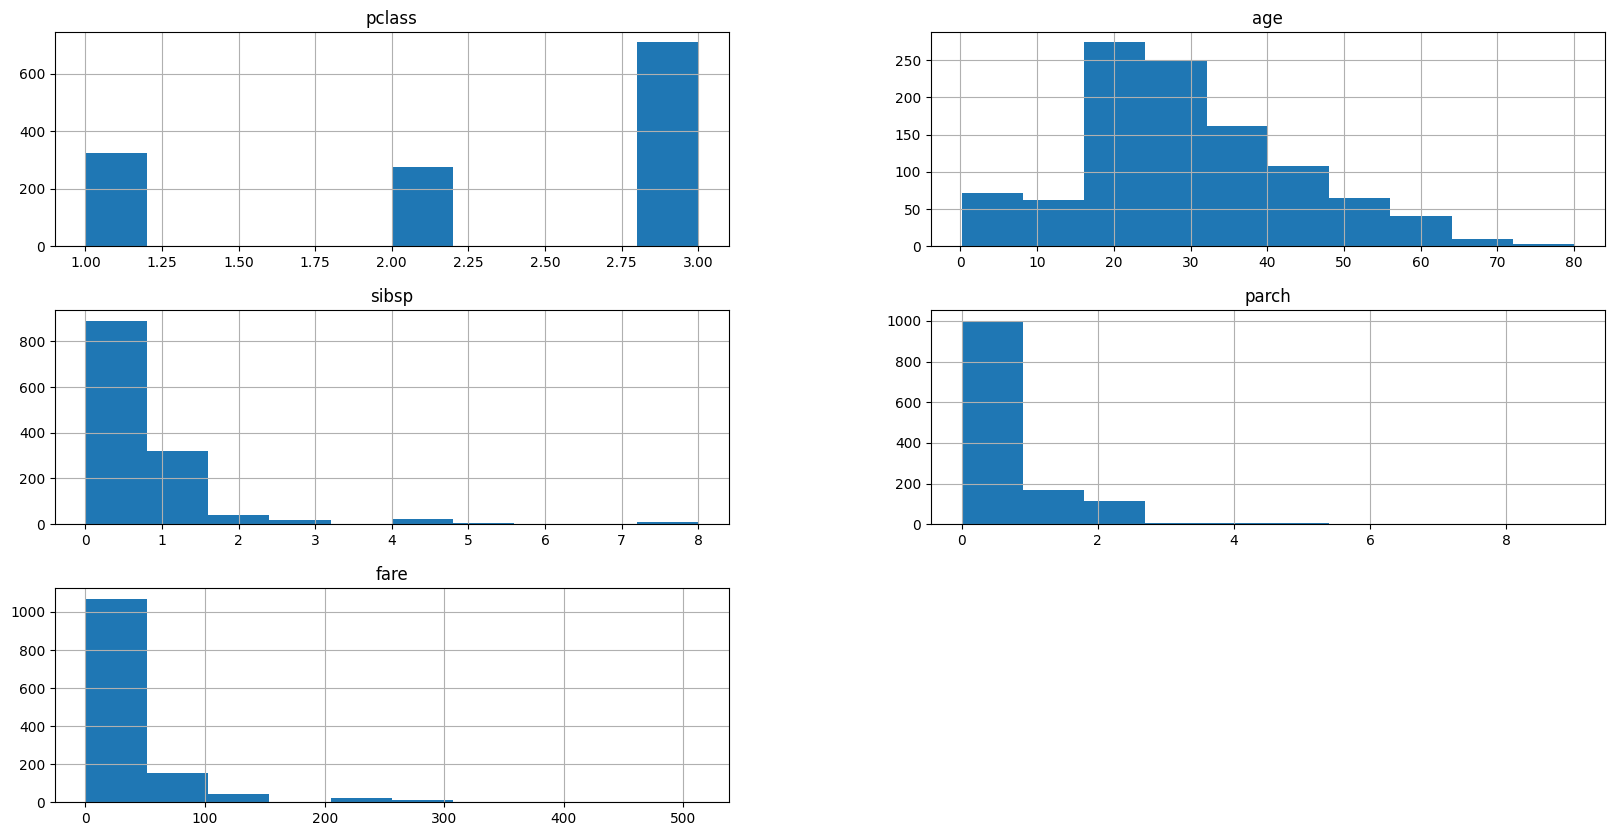

In [15]:
data[vars_num].hist(bins=10, figsize=(20, 10))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [17]:
# data['cabin_1_letter'] = data['cabin'].str.extract('([A-Za-z])', expand=False)
data['cabin'].str.extract('([A-Za-z])', expand=False)

0         B
1         C
2         C
3         C
4         C
5         E
6         D
7         A
8         C
9       NaN
10        C
11        C
12        B
13      NaN
14        A
15      NaN
16        B
17        B
18        D
19        C
20        D
21        D
22        C
23      NaN
24        C
25      NaN
26        B
27        B
28        C
29        C
30        T
31        A
32        C
33        C
34        D
35      NaN
36        E
37      NaN
38        A
39        B
40      NaN
41        B
42        C
43        D
44        E
45        B
46      NaN
47        E
48      NaN
49        B
50        B
51        B
52      NaN
53      NaN
54        B
55        B
56        B
57        B
58      NaN
59      NaN
60        C
61        C
62        E
63        E
64        E
65        E
66        B
67        B
68        A
69        E
70      NaN
71        C
72        C
73      NaN
74        A
75        E
76        E
77        E
78        E
79        C
80      NaN
81        B
82        B
83  

In [18]:
# data['cabin_test'] = str(data['cabin'])[0]
data['cabin'].str.extract('([A-Za-z])', expand=False)

0         B
1         C
2         C
3         C
4         C
5         E
6         D
7         A
8         C
9       NaN
10        C
11        C
12        B
13      NaN
14        A
15      NaN
16        B
17        B
18        D
19        C
20        D
21        D
22        C
23      NaN
24        C
25      NaN
26        B
27        B
28        C
29        C
30        T
31        A
32        C
33        C
34        D
35      NaN
36        E
37      NaN
38        A
39        B
40      NaN
41        B
42        C
43        D
44        E
45        B
46      NaN
47        E
48      NaN
49        B
50        B
51        B
52      NaN
53      NaN
54        B
55        B
56        B
57        B
58      NaN
59      NaN
60        C
61        C
62        E
63        E
64        E
65        E
66        B
67        B
68        A
69        E
70      NaN
71        C
72        C
73      NaN
74        A
75        E
76        E
77        E
78        E
79        C
80      NaN
81        B
82        B
83  

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [19]:
for var in vars_num:
    if data[var].isnull().mean()>0:
        data[var+'_NA'] = np.where(data[var].isnull(), 1, 0)
        
for var in vars_num:
    if data[var].isnull().mean()>0:
        median_val = X_train[var].median()
        data[var].fillna(median_val, inplace=True)

In [20]:
data[vars_num].isnull().sum()

pclass    0
age       0
sibsp     0
parch     0
fare      0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [21]:
vars_cat_with_missing = [i for i in data[vars_cat] if data[i].isnull().sum() > 0]
for i in vars_cat_with_missing:
    data[i].fillna('Missing',inplace=True)

In [22]:
data.shape

(1309, 12)

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [23]:
for i in data[vars_cat].columns.tolist():
    counts = data[i].value_counts(normalize=True)
    labels_to_remove = counts[counts < 0.05].index
    data[i] = np.where(data[i].isin(labels_to_remove), 'Other', data[i])

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
# Perform one-hot encoding of categorical variables into k-1 binary variables
cat_vars = data.select_dtypes(include=['object']).columns.tolist()
for var in cat_vars:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    # Fit and transform data with one-hot encoder
    encoded_data = encoder.fit_transform(data[var].to_numpy().reshape(-1, 1))
    # Create new column names for binary variables
    new_cols = [var+'_'+str(i) for i in range(encoded_data.shape[1])]
    # Create DataFrame with new binary variables
    encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=data.index)
    # Drop original categorical variable and append new binary variables to DataFrame
    data.drop(columns=[var], inplace=True)
    data = pd.concat([data, encoded_df], axis=1)


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   age         1309 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   fare        1309 non-null   float64
 6   age_NA      1309 non-null   int32  
 7   fare_NA     1309 non-null   int32  
 8   sex_0       1309 non-null   float64
 9   cabin_0     1309 non-null   float64
 10  embarked_0  1309 non-null   float64
 11  embarked_1  1309 non-null   float64
 12  embarked_2  1309 non-null   float64
 13  title_0     1309 non-null   float64
 14  title_1     1309 non-null   float64
 15  title_2     1309 non-null   float64
dtypes: float64(10), int32(2), int64(4)
memory usage: 153.5 KB


### Scale the variables

- Use the standard scaler from Scikit-learn

In [27]:
from sklearn.preprocessing import StandardScaler

# scale the variables
num_vars = data[vars_num].columns.tolist()
scaler = StandardScaler()
data[num_vars] = scaler.fit_transform(data[num_vars])

In [28]:
data.dtypes

pclass        float64
survived        int64
age           float64
sibsp         float64
parch         float64
fare          float64
age_NA          int32
fare_NA         int32
sex_0         float64
cabin_0       float64
embarked_0    float64
embarked_1    float64
embarked_2    float64
title_0       float64
title_1       float64
title_2       float64
dtype: object

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [29]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(data, data['survived'], test_size=0.2, random_state=0)

In [30]:
X_train = X_train.drop('survived', axis=1)
X_test = X_test.drop('survived', axis=1)

In [31]:
print(X_train.shape), print(X_test.shape)
print(y_train.shape), print(y_test.shape)

(1047, 15)
(262, 15)
(1047,)
(262,)


(None, None)

In [32]:
# Train logistic regression model
logreg = LogisticRegression(penalty='l2', C=1/0.0005, random_state=0,max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(C=2000.0, max_iter=1000, random_state=0)

In [54]:
y_test

1139    0
533     1
459     0
1150    0
393     0
1189    1
5       1
231     1
330     0
887     1
531     0
790     0
427     1
1260    1
251     1
486     0
436     1
31      1
186     1
1051    0
769     0
642     0
1087    0
55      1
678     0
358     1
503     1
995     0
1005    0
1279    0
916     1
159     1
349     1
224     0
161     1
1168    0
996     0
52      0
1166    0
1125    0
813     0
397     0
215     0
549     1
878     0
1103    0
960     0
141     1
1240    1
1291    0
458     1
874     1
1019    0
1100    0
609     0
1041    0
198     1
610     0
725     1
482     1
846     0
45      0
1208    0
1256    1
1209    0
445     0
422     0
1243    0
1117    0
695     0
589     1
638     0
152     1
1287    0
1012    0
18      1
408     0
233     1
961     0
1000    1
268     0
794     1
474     0
47      1
1002    1
108     1
443     0
793     0
528     0
858     1
942     0
1302    0
773     0
717     0
1179    0
142     0
1236    1
1028    1
420     0
85      1


In [33]:
# Predict on test set and evaluate accuracy
from sklearn.metrics import accuracy_score
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)

print('Accuracy of logistic regression model: {:.3f}'.format(acc))

Accuracy of logistic regression model: 0.813


## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [34]:
# calculate roc-auc
roc_auc = roc_auc_score(y_test, y_pred_prob)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print('ROC-AUC: {:.4f}'.format(roc_auc))
print('Accuracy: {:.4f}'.format(accuracy))

ROC-AUC: 0.8596
Accuracy: 0.8130


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**